In [5]:
import casadi as ca
import numpy as np
from scipy import sparse
import control as ct
import osqp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, timezone

def linearise(params):

    x = ca.SX.sym("x", 12)
    u = ca.SX.sym("u", 4)

    # non linear dynamics
    x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
    u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

    dx_x = x_dx
    dx_y = x_dy
    dx_z = x_dz
    dx_phi = x_dphi
    dx_theta = x_dtheta
    dx_psi = x_dpsi

    ## Dynamics
    #dx_dx = (-1*u_F/params['mass']) * (ca.sin(x_theta))
    #dx_dy = (-1*u_F/params['mass']) * (-ca.sin(x_phi)*ca.cos(x_theta))
    #dx_dz = (-1*u_F/params['mass']) * (ca.cos(x_phi) * ca.cos(x_theta)) + params['gravity']

    dx_dx = -1*u_F/params['mass'] * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
    dx_dy = -1*u_F/params['mass'] * (ca.sin(x_psi)*ca.sin(x_theta)*ca.cos(x_phi) - ca.cos(x_psi)*ca.sin(x_phi))
    dx_dz = -1*u_F/params['mass'] * ca.cos(x_phi) * ca.cos(x_theta) + params['gravity']

    dx_dphi   = 1/params['Ix'] * (u_Tx + x_dtheta * x_dpsi*(params['Iy'] - params['Iz']))
    dx_dtheta = 1/params['Iy'] * (u_Ty + x_dpsi*x_dphi*(params['Iz'] - params['Ix']))
    dx_dpsi   = 1/params['Iz'] * (u_Tz + x_dphi*x_dtheta*(params['Ix']-params['Iy']))

    x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
    f = x_dot
    dynamics = ca.Function("quadrotor_dyn", [x, u], [x + params['step'] * x_dot])

    x_operating = np.zeros((12, 1))
    u_operating = np.array([params['mass']*params['gravity'], 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

    A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
    B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
    C = np.eye(12)
    D = np.zeros((12, 4))

    #make numerical matrices and cast into numpy array
    A = np.array(ca.DM(A))
    B = np.array(ca.DM(B))

    lin_ss_cont = ct.ss(A,B,C,D)
    lin_ss_disc = ct.c2d(lin_ss_cont, params['step'], method='zoh')

    return (lin_ss_disc.A, lin_ss_disc.B, dynamics)

def setup(params, linA, linB, horizon=10):

    ## NOTE We are assuming N=10 here - should probably generalise it

    # Define problem data
    ## Change to np.diagonal
    #p = np.block([[np.eye(120,120), np.zeros((120,40))],[np.zeros((40,120)), np.eye(40,40)]])
    #p = np.block([[np.eye(120,120), np.zeros((120,40))],[np.zeros((40,120)), np.zeros((40,40))]])

    x_penalty = np.tile(params['state_penalty'],10)
    u_penalty = np.tile(params['control_penalty'],10)

    ## Create p penalty matrix. We don't penalise any of the inputs so we zero-out their penalty values here
    #p = np.block([[np.diag(x_penalty), np.zeros((120,40))],[np.zeros((40,120)), np.zeros((40,40))]])
    p = np.block([[np.diag(x_penalty), np.zeros((120,40))],
                  [np.zeros((40,120)), np.diag(u_penalty)]])

    ## Increase TERMINAL constraint
    for i in range(0,12):
        #p[108+i][108+i] = [10*e for e in x_penalty][i]
        p[108+i][108+i] = [params['terminal_multiplier']*e for e in x_penalty][i]

    l = np.zeros((240,1))
    u = np.zeros((240,1))
    A = np.zeros((240,160))

    ## Arrays are addressed by (row, column)

    ## Part 1. Input limits (rows 0:40)
    m_a0 = 121951.2195122
    m_a1 = 938086.30393996
    m_a2 = 609756.09756098
    m_a3 = 6097560.97560975

    for i in range(0,40,4) :
        l[i] = -params['mass']*params['gravity']
        u[i] = params['force_max'] - params['mass']*params['gravity']
        l[i+1] = params['roll_torque_min']
        u[i+1] = params['roll_torque_max']
        l[i+2] = params['pitch_torque_min']
        u[i+2] = params['pitch_torque_max']
        l[i+3] = params['yaw_torque_min']
        u[i+3] = params['yaw_torque_max']
        
        A[i,120+i] = 1
        A[i+1,120+i+1] = 1
        A[i+2,120+i+2] = 1
        A[i+3,120+i+3] = 1

        '''
        l[i] = 1200*1200 - m_a0*params['mass']*params['gravity']
        u[i] = 1900*1900 - m_a0*params['mass']*params['gravity']
        l[i+1] = 1200*1200 - m_a0*params['mass']*params['gravity']
        u[i+1] = 1900*1900 - m_a0*params['mass']*params['gravity']
        l[i+2] = 1200*1200 - m_a0*params['mass']*params['gravity']
        u[i+2] = 1900*1900 - m_a0*params['mass']*params['gravity']
        l[i+3] = 1200*1200 - m_a0*params['mass']*params['gravity']
        u[i+3] = 1900*1900 - m_a0*params['mass']*params['gravity']
        
        A[i,120+i] = m_a0
        A[i,120+i+1] = -m_a1
        A[i,120+i+2] = m_a2
        A[i,120+i+3] = m_a3

        A[i+1,120+i] = m_a0
        A[i+1,120+i+1] = m_a1
        A[i+1,120+i+2] = -m_a2
        A[i+1,120+i+3] = m_a3

        A[i+2,120+i] = m_a0
        A[i+2,120+i+1] = -m_a1
        A[i+2,120+i+2] = -m_a2
        A[i+2,120+i+3] = -m_a3

        A[i+3,120+i] = m_a0
        A[i+3,120+i+1] = m_a1
        A[i+3,120+i+2] = m_a2
        A[i+3,120+i+3] = -m_a3
        '''

    ## Part 2. Roll/Pitch Angle limits (rows 40:60)
    for i in range(0,10):
        l[40+2*i] = params['roll_min']
        u[40+2*i] = params['roll_max']
        l[40+2*i+1] = params['pitch_min']
        u[40+2*i+1] = params['pitch_max']

        A[40+2*i,12*i+3] = 1
        A[40+2*i+1,12*i+4] = 1

    ## Part 3. Velocity Constraints (rows 60:90)
    for i in range(0,10):
        ## Updated from [-2,2]
        l[60+3*i] = params['xvel_min']
        u[60+3*i] = params['xvel_max']
        l[60+3*i+1] = params['yvel_min']
        u[60+3*i+1] = params['yvel_max']
        l[60+3*i+2] = params['zvel_min']
        u[60+3*i+2] = params['zvel_max']

        A[60+3*i,12*i+6] = 1
        A[60+3*i+1,12*i+7] = 1
        A[60+3*i+2,12*i+8] = 1

    ## Part 4. Angular Rate Constraints (rows 90:120)
    for i in range(0,10):
        l[90+3*i] = params['roll_vel_min']
        u[90+3*i] = params['roll_vel_max']
        l[90+3*i+1] = params['pitch_vel_min']
        u[90+3*i+1] = params['pitch_vel_max']
        l[90+3*i+2] = params['yaw_vel_min']
        u[90+3*i+2] = params['yaw_vel_max']

        A[90+3*i,12*i+9] = 1
        A[90+3*i+1,12*i+10] = 1
        A[90+3*i+2,12*i+11] = 1

    ## Part 5. System Dynamics (as constraints) (rows 120:240)
    for i in range(0,10):
        ## Add identity matrix
        A[120+12*i:120+12*(i+1),12*i:12*(i+1)] = np.eye(12)

        ## Add A matrix but skip in first iteration
        if i!=0:
            A[120+12*i:120+12*(i+1), 12*(i-1):12*i] = -1*linA

        ## Add B matrix
        A[120+12*i:120+12*(i+1), 120+4*i:120+4*(i+1)] = -1*linB

    ## NOTE This happens as part of iteration -- Part 6. Lower and upper with initial state (this is what gets updated each step)

    ## Convert to sparse matrix NOTE This should just be used originally
    p = sparse.csc_matrix(p)
    A = sparse.csc_matrix(A)

    return (p, A, l, u)


def loop(params, num_iterations, p, A, l, u, linA, linB, dynamics):

    u_loop = []
    x_loop = []
    statuses = []
    solvetimes = []

    # We use a 0.1s step time for 10 seconds (100 steps)
    # Each step, we update the lower and upper matrix with the current state vector
    # For reference tracking, we also need a q matrix to be updated with the state reference vector (for the states we are controlling)


    prob = osqp.OSQP()
    prob.setup(p, None, A, l, u, alpha=1.0, verbose=False)

    prob.codegen('./cgen', force_rewrite=True)

    x0 = params['initial_state']

    for i in range(0,num_iterations):
        ## Store state vector for plotting
        x_loop.append(x0)
        
        ## Update l and u matrices
        l[120:120+12] = np.matmul(linA, x0).reshape((12,1))
        u[120:120+12] = np.matmul(linA, x0).reshape((12,1))

        ## Update q NOTE q (reference trajectory) is constant for now
        ref_temp = params['constant_ref']

        if params['reference_limit']:
            ## Constrain the reference trajectory to be within a +-4 band of the current value 
            ref_temp[0] = x0[0] + min(4,max(-4, params['constant_ref'][0]-x0[0]))
            ref_temp[1] = x0[1] + min(4,max(-4, params['constant_ref'][1]-x0[1]))
            ref_temp[2] = x0[2] + min(4,max(-4, params['constant_ref'][2]-x0[2]))

        x_ref = np.tile(ref_temp,10)
        x_ref = np.append(x_ref, np.zeros((40,1)))
        q = -1*x_ref@p

        ## Update and solve
        prob.update(l=l, u=u, q=q)
        res = prob.solve()
        statuses.append(res.info.status)
        solvetimes.append(res.info.solve_time)

        ## Extract next control inputs
        if (res.info.status=='solved'):
            u_next = res.x[120:124]
            u_loop.append(u_next)
        else:
            u_loop.append([0,0,0,0])

        ## Recompute system dynamics
        #x0 = np.matmul(linA, x0)+np.matmul(linB,u_next)
        #x0 = np.matmul(linA, x0)+np.matmul(linB,np.array([0,0,0,0]))

        # add-back +mg from the linearised point
        u_next[0] += params['mass']*params['gravity']
        x0 = dynamics(x0, u_next).full().reshape(12,)
        
    print(f'{sum([1 if e=='solved' else 0 for e in statuses])*100/len(statuses)}% solved')
    print(f'Average solve time (ms): {1e3*sum(solvetimes)/len(solvetimes):4.6f}')

    return {'states': x_loop, 'controls': u_loop, 'status': statuses, 'solvetimes': solvetimes}

def generate_c_code(params, path, linA, linB, lower, upper):
    with open(path,'w') as wfile:
        wfile.write("""#include "controller_mpc.h"\n""")
        wfile.write(f"/* Last generated using fulltest.ipynb at {datetime.now(timezone.utc)} */\n")
        wfile.write("""
MPC_Controller::MPC_Controller()
    : MC_Controller(),
    linearised_A{
"""
                   )
        for i in range(0,12):
            for j in range(0,12):
                wfile.write(f"        {linA[i,j]}f, // ({i},{j})\n")
        wfile.write("    },\n    linearised_B{\n")
        for i in range(0,12):
            for j in range(0,4):
                wfile.write(f"        {linB[i,j]}f, // ({i},{j})\n")
        wfile.write("    },\n    lower_constraint{\n")
        for i in range(0,240):
            wfile.write(f"        {lower[i][0]}f, // ({i},0)\n")
        wfile.write("    },\n    upper_constraint{\n")
        for i in range(0,240):
            wfile.write(f"        {upper[i][0]}f, // ({i},0)\n")
        ## Penalty vector
        wfile.write("    },\n    penalty_vector{\n")
        for i in range(0,120):
            wfile.write(f"        {params['state_penalty'][i%12]}.0f, // ({i},0)\n")
        wfile.write("    }\n{\n    for (int i=0;i<160;i++) {\n        q_constraint[i]=0.0f;\n    }\n}\n")

def run(params, generate=False):

    iterations = int(params['runtime']/params['step'])

    linA, linB, dyn = linearise(params)

    p, A, l, u = setup(params, linA, linB, 10)

    output = loop(params, iterations, p, A, l, u, linA, linB, dyn)

    ## TODO Fix this absolute path reference
    if generate:
        generate_c_code(params, '../../../controller_mpc_constructor.cpp', linA, linB, l, u)

    return output

100.0% solved
Average solve time (ms): 0.082028
[[   83333.33333333  -641025.64102564   416666.66666667  4166666.66666667]
 [   83333.33333333   641025.64102564  -416666.66666667  4166666.66666667]
 [   83333.33333333  -641025.64102564  -416666.66666667 -4166666.66666667]
 [   83333.33333333   641025.64102564   416666.66666667 -4166666.66666667]]
(4, 2000)
(2000,)


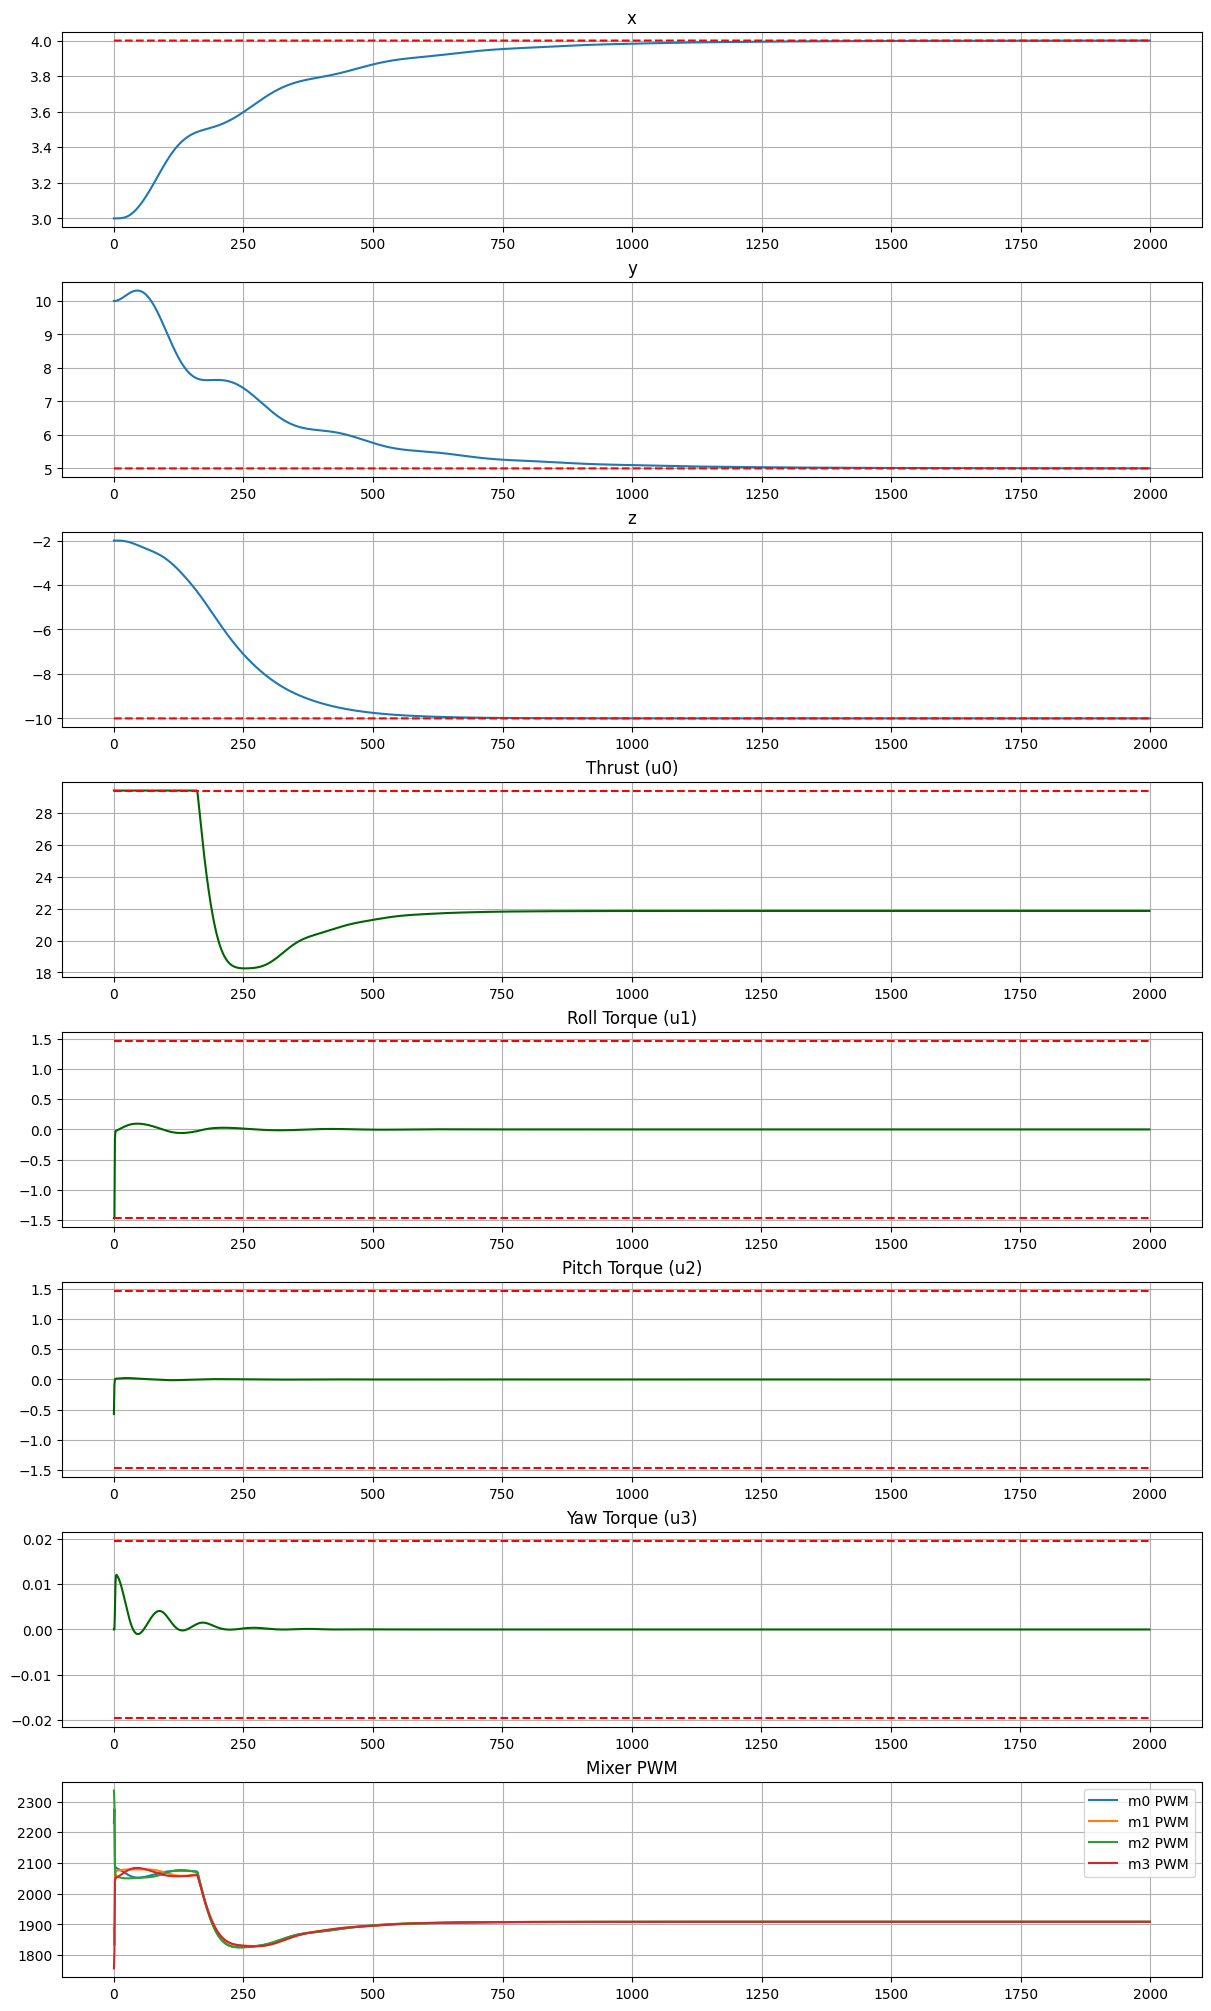

In [21]:
if __name__=="__main__":

    params = {
            ## Geometry and environment variables
            'mass':  2.23, # kg
            'gravity': 9.8, # m/s
            'Ix': 0.008,
            'Iy': 0.015,
            'Iz': 0.017,
            'L': 0.2,

            ## Constraint Variables
            'force_max': 29.4,
            'roll_torque_min': -1.475,
            'roll_torque_max':  1.475,
            'pitch_torque_min': -1.475,
            'pitch_torque_max':  1.475,
            'yaw_torque_min': -0.0196,
            'yaw_torque_max': 0.0196,

            'roll_min': -np.pi/2,
            'roll_max': np.pi/2,
            'pitch_min': -np.pi/2,
            'pitch_max': np.pi/2,

            'xvel_min': -1e6, 
            'xvel_max': 1e6,
            'yvel_min': -1e6,
            'yvel_max': 1e6,
            'zvel_min': -1e6,
            'zvel_max': 1e6,

            'roll_vel_min': -3*np.pi,
            'roll_vel_max': 3*np.pi,
            'pitch_vel_min': -3*np.pi,
            'pitch_vel_max': 3*np.pi,
            'yaw_vel_min': -3*np.pi,
            'yaw_vel_max': 3*np.pi,

            ## Reference
            'constant_ref': np.array([4, 5, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0]),

            ## Initial
            'initial_state': np.array([3, 10, -2, 0.75, 0, 0, 0, 0, 0, 0, 0, 0]),

            ## Penalty
            'state_penalty': np.array([100,100,100, 5,5,5, 10,10,10, 1,1,1]),
            'terminal_multiplier': 10,
            'control_penalty': np.array([0.1,0.1,0.1,0.1]),

            ## Flags
            'reference_limit': False,

            ## Simulation variables
            'step': 0.01,
            'runtime': 20 ## seconds
            }

    output = run(params, generate=False)

    iterations = int(params['runtime']/params['step'])

    ## GRAPH STATE
    x = [output['states'][i][0] for i in range(0,iterations)]
    y = [output['states'][i][1] for i in range(0,iterations)]
    z = [output['states'][i][2] for i in range(0,iterations)]

    fig = plt.figure(figsize=(12, 20), constrained_layout=True)

    ax = fig.add_subplot(8,1,1)
    ax.plot(range(0,len(x)),x, label='x')
    ax.plot(range(0,len(x)), params['constant_ref'][0].repeat(iterations), linestyle='--', color='red')
    ax.set_title('x')
    ax.grid(True)

    ax = fig.add_subplot(8,1,2)
    ax.plot(range(0,len(y)),y)
    ax.plot(range(0,len(y)), params['constant_ref'][1].repeat(iterations), linestyle='--', color='red')
    ax.set_title('y')
    ax.grid(True)

    ax = fig.add_subplot(8,1,3)
    ax.plot(range(0,len(z)),z)
    ax.plot(range(0,len(z)), params['constant_ref'][2].repeat(iterations), linestyle='--', color='red')
    ax.set_title('z')
    ax.grid(True )

    ## GRAPH CONTROL VECTOR
    u0 = [output['controls'][i][0] for i in range(0,iterations)]
    u1 = [output['controls'][i][1] for i in range(0,iterations)]
    u2 = [output['controls'][i][2] for i in range(0,iterations)]
    u3 = [output['controls'][i][3] for i in range(0,iterations)]

    ax = fig.add_subplot(8,1,4)
    ax.plot(range(0,len(u0)),u0, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['force_max']], linestyle='--', color='red')
    ax.set_title('Thrust (u0)')
    ax.grid(True)

    ax = fig.add_subplot(8,1,5)
    ax.plot(range(0,len(u0)),u1, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['roll_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['roll_torque_min']], linestyle='--', color='red')
    ax.set_title('Roll Torque (u1)')
    ax.grid(True)

    ax = fig.add_subplot(8,1,6)
    ax.plot(range(0,len(x)),u2, color='darkgreen')
    ax.set_title('Pitch Torque (u2)')
    ax.plot([0,len(u0)],2*[params['pitch_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['pitch_torque_min']], linestyle='--', color='red')
    ax.grid(True)

    ax = fig.add_subplot(8,1,7)
    ax.plot(range(0,len(x)),u3, color='darkgreen')
    ax.plot([0,len(u0)],2*[params['yaw_torque_max']], linestyle='--', color='red')
    ax.plot([0,len(u0)],2*[params['yaw_torque_min']], linestyle='--', color='red')
    ax.set_title('Yaw Torque (u3)')
    ax.grid(True)

    ### Mixer PWM Outputs
    '''
    allocation = np.array([[121951.2195122, -938086.30393996, 609756.09756098, 6097560.97560975],
                           [121951.2195122, 938086.30393996, -609756.09756098, 6097560.97560976],
                           [121951.2195122, -938086.30393996, -609756.09756098, -6097560.97560975],
                           [121951.2195122, 938086.30393996, 609756.09756098, -6097560.97560976]]
                         )
    '''
    ylen = 0.13
    xlen = 0.2
    kt = 3e-6
    km = 0.02*kt
    preinv = np.array([[kt, kt, kt, kt],
                  [-ylen*kt, ylen*kt, -ylen*kt, ylen*kt],
                  [xlen*kt, -xlen*kt, -xlen*kt, xlen*kt],
                  [km, km, -km, -km]])
    allocation = np.linalg.pinv(preinv)
    print(allocation)

    ctl = np.vstack((np.add(u0,params['mass']*params['gravity']), u1, u2, u3))
    out = allocation@ctl
    out = np.sqrt(out)
    print(out.shape)
    print(out[0,:].shape)

    ax = fig.add_subplot(8,1,8)
    ax.plot(out[0,:], label='m0 PWM')
    ax.plot(out[1,:], label='m1 PWM')
    ax.plot(out[2,:], label='m2 PWM')
    ax.plot(out[3,:], label='m3 PWM')
    ax.set_title('Mixer PWM')
    ax.grid(True)
    ax.legend()

    plt.show()

    